# Advanced Interval Plotting
Author(s): Paul Miles | Date: July 13, 2018

#### Return to [Index](https://nbviewer.jupyter.org/github/prmiles/notebooks/blob/master/pymcmcstat/index.ipynb)

For the purpose of this example we will consider the Monod model demonstrated [here](https://nbviewer.jupyter.org/github/prmiles/notebooks/blob/master/pymcmcstat/monod/Monod.ipynb).

In [5]:
import numpy as np
import scipy.optimize
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt

# Initialize MCMC object
mcstat = MCMC()

# Next, create a data structure for the observations and control
# variables. Typically one could make a structure |data| that
# contains fields |xdata| and |ydata|.
ndp = 7
x = np.array([28,    55,    83,    110,   138,   225,   375])   # (mg / L COD)
x = x.reshape(ndp,1) # enforce column vector
y = np.array([0.053, 0.060, 0.112, 0.105, 0.099, 0.122, 0.125]) # (1 / h)
y = y.reshape(ndp,1) # enforce column vector

# data structure 
mcstat.data.add_data_set(x,y)

def modelfun(x, theta):
    return theta[0]*x/(theta[1] + x)

def ssfun(theta,data):
    return sum((data.ydata[0] - modelfun(data.xdata[0], theta))**2)

# Calculate initial covariance matrix
def residuals(p, x, y):
    return y - modelfun(x, p)
theta0, ssmin = scipy.optimize.leastsq(residuals, x0 = [0.15, 100], args=(mcstat.data.xdata[0].reshape(ndp,), mcstat.data.ydata[0].reshape(ndp,)))
n = mcstat.data.n[0] # number of data points in model
p = len(theta0); # number of model parameters (dof)
ssmin = ssfun(theta0, mcstat.data) # calculate the sum-of-squares error
mse = ssmin/(n-p) # estimate for the error variance
J = np.array([[x/(theta0[1]+x)], [-theta0[0]*x/(theta0[1]+x)**2]])
J = J.transpose()
J = J.reshape(n,p)
tcov = np.linalg.inv(np.dot(J.transpose(),J))*mse

# Define model parameters, simulation options, and model settings.
mcstat.parameters.add_model_parameter(name = '$\mu_{max}$', theta0 = theta0[0], minimum = 0)
mcstat.parameters.add_model_parameter(name = '$K_x$', theta0 = theta0[1], minimum = 0)
mcstat.simulation_options.define_simulation_options(nsimu = int(5.0e3), updatesigma = 1, qcov = tcov)
mcstat.model_settings.define_model_settings(sos_function = ssfun, sigma2 = 0.01**2)

# Run simulation
mcstat.run_simulation()

# Extract results and print statistics
results = mcstat.simulation_results.results
names = results['names']
chain = results['chain']
s2chain = results['s2chain']
names = results['names'] # parameter names
mcstat.chainstats(chain, results)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
$\mu_{max}$:      0.15 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
     $K_x$:     49.05 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 1.1 sec
---------------------
name      :       mean        std     MC_err        tau     geweke
$\mu_{max}$:     0.1574     0.0295     0.0021    21.7761     0.9966
$K_x$     :    66.4455    38.7130     3.0242    23.0492     0.9764
---------------------


### Plot Credible/Prediction Intervals
Define function for generating intervals, setup calculations, and generate.

In [10]:
def predmodelfun(data, theta):
    return modelfun(data.xdata[0], theta)

mcstat.PI.setup_prediction_interval_calculation(results = results, data = mcstat.data, 
                                                modelfunction = predmodelfun)
mcstat.PI.generate_prediction_intervals(nsample = 500, calc_pred_int = False)

def format_plot():
    plt.xlabel('x (mg/L COD)',Fontsize=20)
    plt.xticks(Fontsize=20)
    plt.ylabel('y (1/h)',Fontsize=20)
    plt.yticks(Fontsize=20)
    plt.title('Predictive envelopes of the model',Fontsize=20);

Generating credible/prediction intervals:


Interval generation complete



# Plotting
Available inputs: (Defaults in Parantheses)
- `plot_pred_int`: Flag to include PI on plot. (`True`)
- `adddata`: Flag to include data on plot. (`False`)
- `addlegend`: Flag to include legend on plot. (`True`)
- `figsizeinches`: Specify figure size in inches [Width, Height]. (`[7,5]`)
- `model_display`: Model display settings. (See below)
- `data_display`: Data display settings. (See below)
- `interval_display`: Interval display settings. (See below)

Default display options:
- `interval_display = {'linestyle': ':', 'linewidth': 1, 'alpha': 0.5, 'edgecolor': 'k'}`
- `model_display = {'linestyle': '-', 'marker': '', 'color': 'r', 'linewidth': 2, 'markersize': 5, 'label': 'model', 'alpha': 1.0}`
- `data_display = {'linestyle': '', 'marker': '.', 'color': 'b', 'linewidth': 1, 'markersize': 5, 'label': 'data', 'alpha': 1.0}`

## Case 1: Use default settings

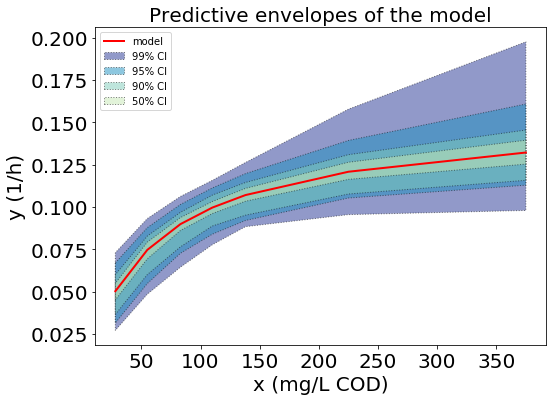

In [13]:
mcstat.PI.plot_prediction_intervals()
format_plot()

## Case 2: Include Data and Adjust Appearance

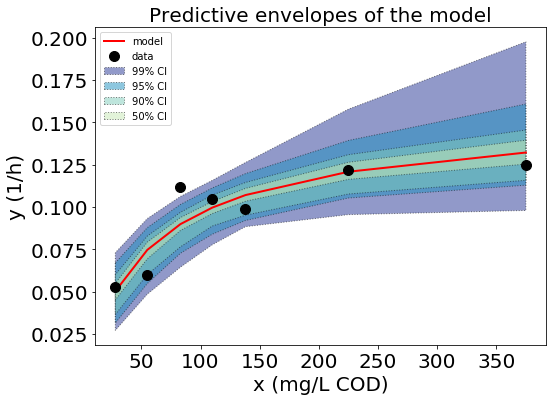

In [39]:
data_display = {'marker': 'o', 'color': 'k', 'markersize': 10}
mcstat.PI.plot_prediction_intervals(adddata=True, data_display = data_display)
format_plot()

## Case 3: Adjust Appearance of Model

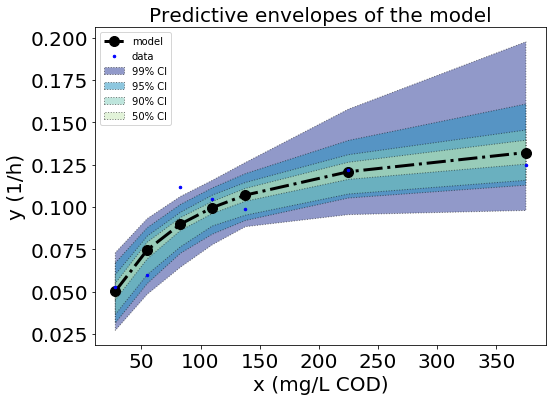

In [47]:
model_display = {'linestyle': '-.', 'linewidth': 3, 'color': 'k', 'marker': 'o', 'markersize': 10}
mcstat.PI.plot_prediction_intervals(adddata=True, model_display = model_display)
format_plot()

## Case 3: Adjust Appearance of Intervals

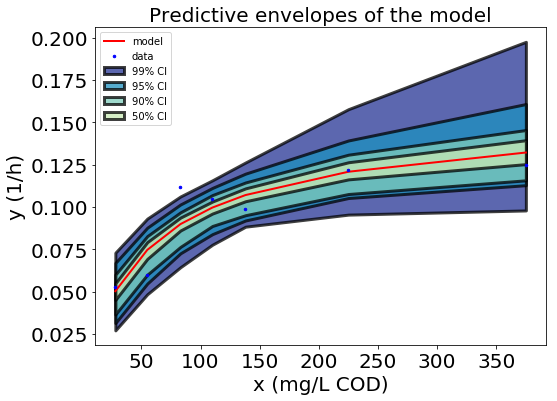

In [53]:
interval_display = {'linestyle': '-', 'linewidth': 3, 'alpha': 0.75, 'edgecolor': 'k'}
mcstat.PI.plot_prediction_intervals(adddata=True, interval_display = interval_display)
format_plot()